# Feasibility study
---
## Data preprocessing

Installing a package that does not come pre-installed in this environment. We would need this for a visualization later.

In [ ]:
pip install missingno

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew

# These are plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%matplotlib inline


%load_ext autoreload

pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 99)

## 0- Reading the data

In [ ]:
# Update your name in the path below
df_train = pd.read_csv('../input/house-prices-data/train.csv')

keep_cols = [
    # "Id",
    "SalePrice",
    "OverallQual",
    "GrLivArea",
    "TotalBsmtSF",
    "YearBuilt",
    # "GarageArea",
    "GarageCars",
    "FullBath",
    # "1stFlrSF",
    # "TotRmsAbvGrd",
    "LandContour",
    "CentralAir",
    "FireplaceQu",
    "PoolQC",
    "BsmtFullBath",
    "BsmtCond",
    "BsmtExposure",
    "LotFrontage",
    "Neighborhood",
    "SaleCondition",
]

df_train = df_train[keep_cols]

df_train.head()

In [ ]:
TARGET = "SalePrice"

NUMERICAL_FEATURES = df_train.select_dtypes(include=["int", "float"]).columns.to_list()
NUMERICAL_FEATURES.remove(TARGET)
NUMERICAL_FEATURES.remove('OverallQual')
NUMERICAL_FEATURES.remove('YearBuilt')

CAT_FEATURES = df_train.select_dtypes(include=["object"]).columns.to_list() + ['OverallQual', 'YearBuilt']

df_train.shape

## 1- Remove outliers 

In [ ]:
sns.boxplot(x=df_train[TARGET])

Outliers: one of the strategies to detect and remove outliers is:

```
q1 = df_train[TARGET].quantile(0.25)
q3 = df_train[TARGET].quantile(0.75) 
iqr = q3 - q1
```

Tolerance is 1.5 times IQR beyond Q1 and Q3 each.



---

In [ ]:
q1 = df_train[TARGET].quantile(0.25)
q3 = df_train[TARGET].quantile(0.75)
iqr = q3 - q1

count_outliers = len(df_train[df_train[TARGET] < (q1 - 1.5 * iqr)]) + len(
    df_train[df_train[TARGET] > (q3 + 1.5 * iqr)]
)

print(f"Count of outliers: {count_outliers} out of total rows {len(df_train)}")

In [ ]:
df_train.shape

In [ ]:
# Option 1: Slicing the entire dataframe based on what is not an outlier in the target feature
df_train1 = df_train[(df_train[TARGET] < (q1 - 1.5 * iqr)) & (df_train[TARGET] > (q3 + 1.5 * iqr))]

In [ ]:
q1 = df_train[TARGET].quantile(0.25)
q3 = df_train[TARGET].quantile(0.75)
iqr = q3 - q1
print (q3, '=>', iqr, '=>', q1)

In [ ]:
# Option 2: Tag Cond 1 and 2
cond1 = (df_train[TARGET] > (q1 - 1.5 * iqr))  
cond2 = (df_train[TARGET] < (q3 + 1.5 * iqr))
filter = cond1 & cond2
df_train2 = df_train[filter]

In [ ]:
df_train2.shape

In [ ]:
df_train = df_train2
df_train.shape

---

## 2- Missing data checks and imputation

In [ ]:
msno.matrix(df_train, labels=True)

In [ ]:
df_train.isnull().sum()

In [ ]:
# PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
df_train["PoolQC"] = df_train["PoolQC"].fillna("None")

# FireplaceQu : data description says NA means "no fireplace"
df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna("None")

df_train["GarageCars"] = df_train["GarageCars"].fillna("None")

In [ ]:
df_train["BsmtCond"] = df_train["FireplaceQu"].fillna("None")

df_train["BsmtExposure"] = df_train["FireplaceQu"].fillna("None")

In [ ]:
df_train.info()

Note that all the Bsmt features have missing data in the same observations.<br/>


In [ ]:
# The same with basement features
for col in NUMERICAL_FEATURES:
    if col.startswith("Bsmt"):
        print(col)
        df_train[col].fillna(0, inplace=True)

for col in CAT_FEATURES:
    if col.startswith("Bsmt"):
        print(col)
        df_train[col].fillna("None", inplace=True)

In [ ]:
# LotFrontage
# Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

## 3- Categorical features encoding

In [ ]:
df_train[CAT_FEATURES].head()

Text features cannot be processed by the model. They need to be transformed into numbers.

There is a very simple way to do it called creating dummy features.

For example- you have a feature called Gender which has only 2 distinct values **for now**- Male and Female.

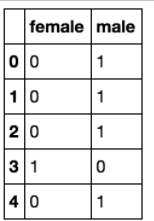

We can drop the last column here as it is redundant. <br/>
So if a feature has `n` levels, you will have (n-1) features after creating dummies out of it. 

In [ ]:
# However, with very high cardinality, it is not a good idea. 
df_train[CAT_FEATURES].nunique()

### Let us bin features with very high cardinality to reduce it

YearBuilt (112)

In [ ]:
sns.distplot(df_train['YearBuilt'])

In [ ]:
# The bin split is subjective for now and can be changed later if it can improve the model performance
df_train['YearBuiltBin'] = pd.cut(x=df_train['YearBuilt'], bins=[1899, 1924, 1949, 1999, 2024]) 
df_train.loc[:10,['YearBuilt','YearBuiltBin']]

df_train.head()

In [ ]:
del df_train['YearBuilt']

CAT_FEATURES.remove('YearBuilt')
CAT_FEATURES.append('YearBuiltBin')

Neighborhood (25)

In [ ]:
plt.figure(figsize=(20,7))
sns.countplot(x='Neighborhood', data=df_train)

I have no information on how to logically group these neighborhoods manually. We can do a research on how to logically do this in a manual fashion or there are advanced ways of encoding this. That is out of scope for now. 

### Creating dummy features


In [ ]:
df_train.shape

In [ ]:
train = pd.get_dummies(df_train, columns=CAT_FEATURES)
train.head()

In [ ]:
train.shape

In [ ]:
# Just double-checking
msno.matrix(train)

## 4- Feature engineering

**Time to get creative!**

This, believe it or not, is the most important part of building a good model.

It is advised to spend enough time researching and brainstorming all the factors that could affect your target feature. <br/>
**TIP** - It helps if you keep the practicality of getting the data for these features out of your prep, as that limits creativity.

### Polynomial transforms

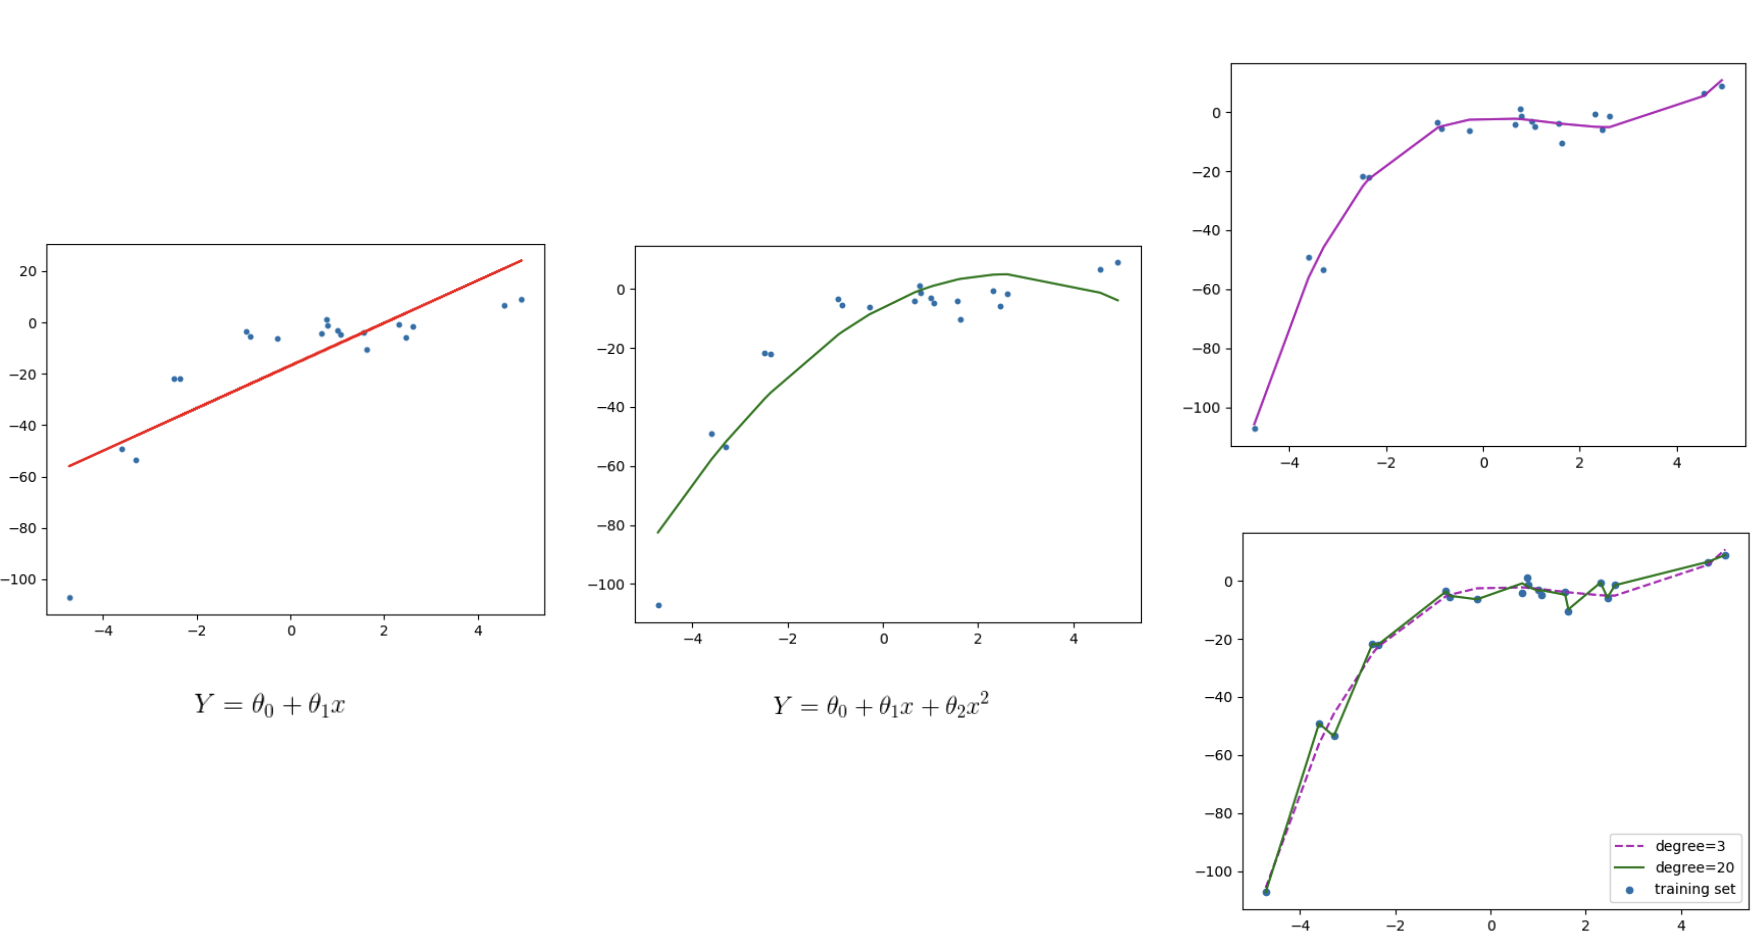

We do not want to use higher degrees than 3 because we do not want to fit every data point. This results in the model learning a bias. This model will not generalise well i.e. it will be less accurate in general because of learning this bias. This is called overfitting- more on this later in the course.

In [ ]:
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])

train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])

train["TotalBsmtSF-2"] = train["TotalBsmtSF"] ** 2
train["TotalBsmtSF-3"] = train["TotalBsmtSF"] ** 3
train["TotalBsmtSF-Sq"] = np.sqrt(train["TotalBsmtSF"])

### Log transform

log(10) = 1 and log(100) = 2<br/>
<br/>
Log transform suppresses the bigger values into smaller ones and you get a less skewed data. This in turn reduced the impact of outliers.

See it in action

In [ ]:
# Before - Skewed distribution
sns.distplot(train['SalePrice'])

In [ ]:
# After - Looks more normal
sns.distplot(np.log1p(train['SalePrice']))

Skewness of perfect normal dist = 0.

**As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed**


In [ ]:
# Let us find our features that have skewness over 0.5
skewness = train[NUMERICAL_FEATURES].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewness.head()

In [ ]:
train['GrLivArea'] = np.log1p(train['GrLivArea'])
train['TotalBsmtSF'] = np.log1p(train['TotalBsmtSF'])
train['LotFrontage'] = np.log1p(train['LotFrontage'])

---

In [ ]:
sns.distplot(train['GarageCars-Sq'])

In [ ]:
# sns.distplot(np.log1p(train['GarageCars-Sq']))
sns.distplot(train['GrLivArea-Sq'])

In [ ]:
MODEL_FEATURES = train.columns.to_list()
MODEL_FEATURES.remove(TARGET)

print(len(MODEL_FEATURES))
# Why do you think we are using a list here instead of a tuple?

In [ ]:
from datetime import datetime, date, time, timedelta

In [ ]:
d = date(2020, 12,16)
d
print(d)

In [ ]:

#Strptime example - String to datetime object
datetime.strptime('2020/11/02 23:33:33 UTC', "%Y/%m/%d %H:%M:%S %Z")
datetime.strptime("21/11/06 16:30", "%d/%m/%y %H:%M")

In [ ]:
#Strftime example - Convert datetime object to string
now = datetime.now() # current date and time

year = now.strftime("%Y")
print("year:", year)

month = now.strftime("%m")
print("month:", month)

day = now.strftime("%d")
print("day:", day)

time = now.strftime("%H:%M:%S")
print("time:", time)

date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
print("date and time:",date_time)

In [ ]:
#Datetime to date 
d = datetime.date(now)
print(d)
d

In [ ]:
# Differene between 2 dates returns days - a timedelta object that has only .days attribute
today = date.today()
random_date = date(2019, 11, 2)
today-random_date

In [ ]:
diff = (today-random_date).days
diff

In [ ]:
# Add nr of days to a date
from random import randint

startdate=datetime.date(2020,5,22)
date=startdate+datetime.timedelta(randint(1,365))
date

In [ ]:
a = datetime(2017, 11, 28, 23, 55, 59, 342380)
print("year =", a.year)
print("month =", a.month)
print("hour =", a.hour)
print("minute =", a.minute)
print("timestamp =", a.timestamp())

In [ ]:
t1 = timedelta(weeks = 2, days = 5, hours = 1, seconds = 33)
t2 = timedelta(days = 4, hours = 11, minutes = 4, seconds = 54)
t3 = t1 - t2 #timedelta object is returned of course

print("t3 =", t3)

In [ ]:
# You can get the total number of seconds in a timedelta object using total_seconds() method.
t1 = date(year = 2018, month = 7, day = 12)
t2 = date(year = 2017, month = 12, day = 23)
t3 = t1 - t2
print("total seconds =", t3.total_seconds())